In [118]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from src.data.cleaning import clean_sensor_data
from src.features.target import add_minutes_to_dry

# --- Indstillinger ---
plt.rcParams["figure.figsize"] = (12, 6)
timestamp_str = datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = f"dataanalysis/diagrams_{timestamp_str}"
os.makedirs(output_dir, exist_ok=True)
print(f"Diagrammer gemmes i: {output_dir}")


# --- Hent data fra API ---
def fetch_api_data(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        if isinstance(data, list):
            df = pd.DataFrame(data)
        elif isinstance(data, dict) and "response" in data and "list" in data["response"]:
            # Nested structure
            df = pd.DataFrame([item["SampleDTO"] for item in data["response"]["list"]])
        else:
            raise ValueError("Uventet struktur fra API.")

        df["timestamp"] = pd.to_datetime(df["timestamp"])
        return df
    else:
        raise ConnectionError(f"API-kald fejlede med status {response.status_code}")


df_raw = fetch_api_data("https://mal-api.whitebush-734a9017.northeurope.azurecontainerapps.io/sensor/data")

print(f"Antal samples: {len(df_raw)}")
print(f"Minimum soil_humidity: {df_raw['soil_humidity'].min()}")


Diagrammer gemmes i: dataanalysis/diagrams_20250516-102305
Antal samples: 468
Minimum soil_humidity: 22


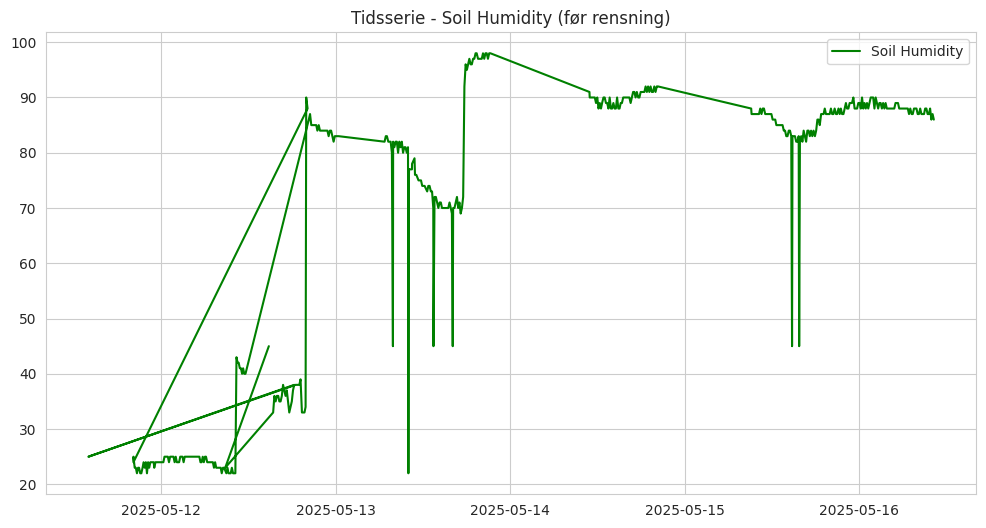

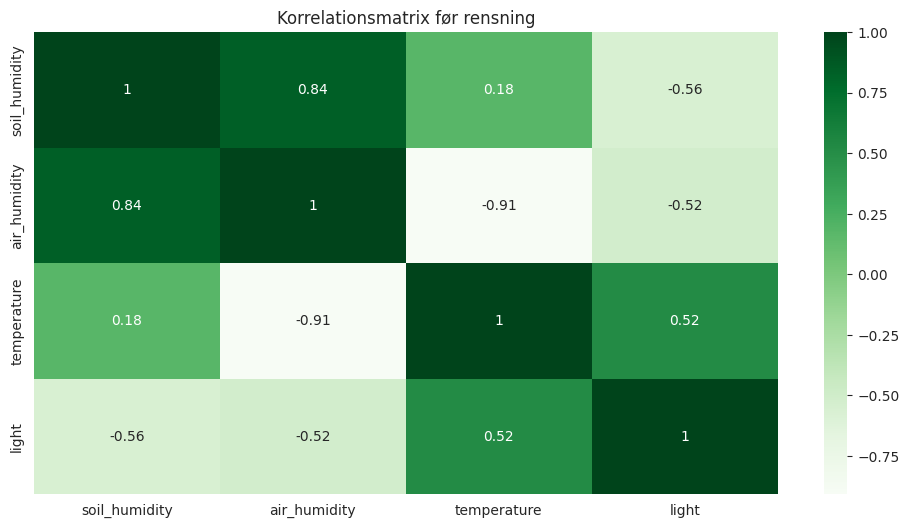

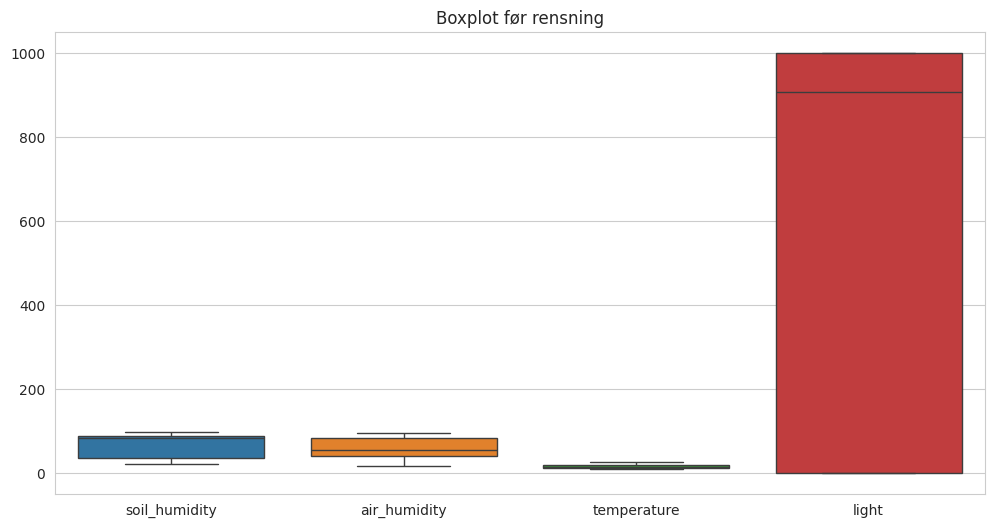

In [119]:
# --- Visualisering før cleaning ---
plt.title("Tidsserie - Soil Humidity (før rensning)")
plt.plot(df_raw['timestamp'], df_raw['soil_humidity'], label='Soil Humidity', color='green')
plt.legend()
plt.savefig(f"{output_dir}/soil_humidity_timeseries_before_cleaning.png")
plt.show()

# Renaming of features
rename_map = {
    "soilhumidity": "soil_humidity",
    "airhumidity": "air_humidity",
    "airtemperature": "temperature",
    "lightvalue": "light",
    "soil_humidity": "soil_humidity",
    "air_humidity": "air_humidity",
    "air_temperature": "temperature",
    "light_value": "light"
}

df_raw.rename(columns={col: rename_map.get(col.lower(), col) for col in df_raw.columns}, inplace=True)

# --- Heatmap raw ---
sns.heatmap(df_raw[["soil_humidity", "air_humidity", "temperature", "light"]].corr(), annot=True, cmap='Greens')
plt.title("Korrelationsmatrix før rensning")
plt.savefig(f"{output_dir}/correlation_matrix_before_cleaning.png")
plt.show()

# --- Boxplot raw ---
sns.boxplot(data=df_raw[["soil_humidity", "air_humidity", "temperature", "light"]])
plt.title("Boxplot før rensning")
plt.savefig(f"{output_dir}/boxplot_before_cleaning.png")
plt.show()


In [120]:
# --- Cleaning ---
df_clean = clean_sensor_data(df_raw.copy(), expected_interval_minutes=10, gap_drop_threshold=60)
print(f"Antal samples efter cleaning: {len(df_clean)}")
print(f"Minimum soil_humidity: {df_clean['soil_humidity'].min()}")
print(f"Maximum soil_humidity: {df_clean['soil_humidity'].max()}")

# --- Creating target variable ---
df_clean = add_minutes_to_dry(df_clean, threshold=83)
df_clean.dropna(subset=["minutes_to_dry"], inplace=True)
print(f"Antal samples efter target lavet: {len(df_clean)}")

# --- Feature engineering ---
df_clean["hour_sin"] = np.sin(df_clean["timestamp"].dt.hour / 24 * 2 * np.pi)
df_clean["hour_cos"] = np.cos(df_clean["timestamp"].dt.hour / 24 * 2 * np.pi)

# --- Feature selection ---
feature_cols = [
    "soil_humidity",
    "soil_delta",
    "air_humidity",
    "temperature",
    "light",
    "hour_sin",
    "hour_cos"
]

print(df_clean[feature_cols].describe())


Antal samples efter cleaning: 113
Minimum soil_humidity: 82
Maximum soil_humidity: 90
Antal samples efter target lavet: 44
       soil_humidity  soil_delta  air_humidity  temperature        light  \
count      44.000000   44.000000     44.000000    44.000000    44.000000   
mean       85.454545   -0.045455     38.227273    18.386364   971.022727   
std         1.970179    0.210707      9.268260     5.239456    35.647818   
min        82.000000   -1.000000     23.000000    12.000000   908.000000   
25%        83.750000    0.000000     29.750000    14.000000   933.750000   
50%        86.000000    0.000000     39.500000    17.000000  1000.000000   
75%        87.000000    0.000000     46.000000    23.250000  1000.000000   
max        88.000000    0.000000     51.000000    27.000000  1000.000000   

           hour_sin   hour_cos  
count  4.400000e+01  44.000000  
mean   2.382246e-02  -0.852656  
std    5.121518e-01   0.128238  
min   -8.660254e-01  -1.000000  
25%   -5.000000e-01  -0.965

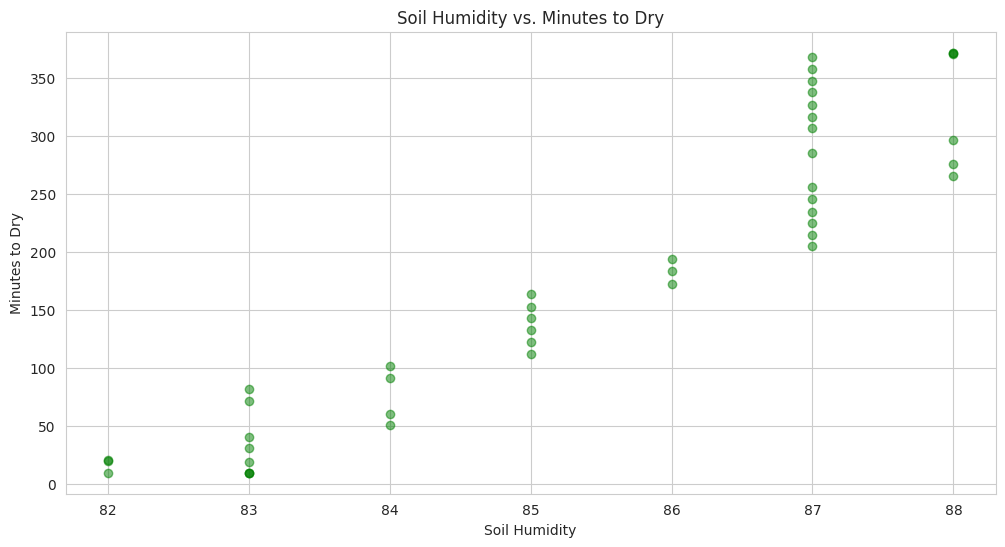

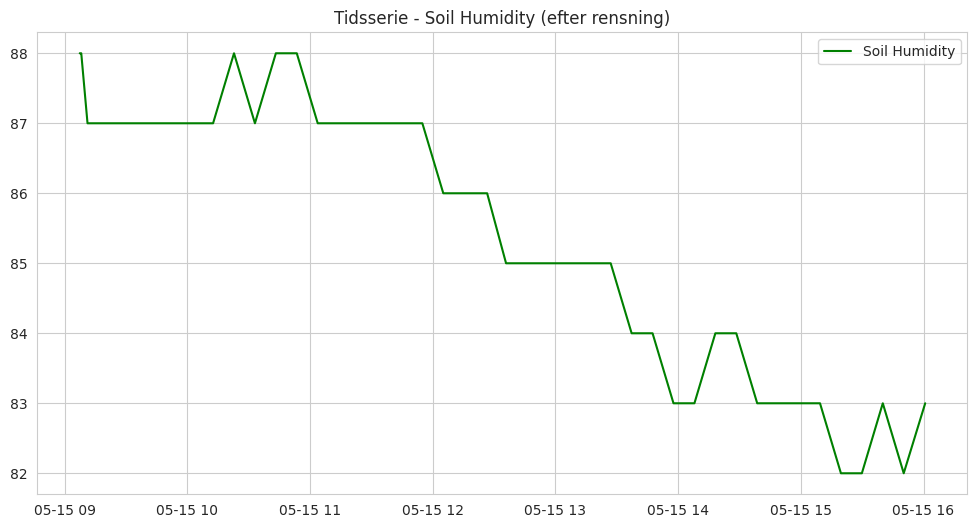

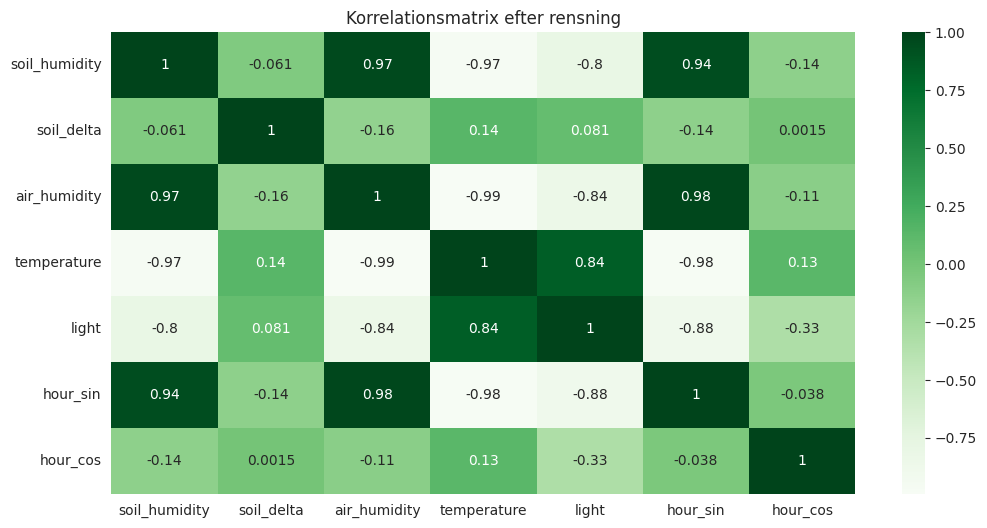

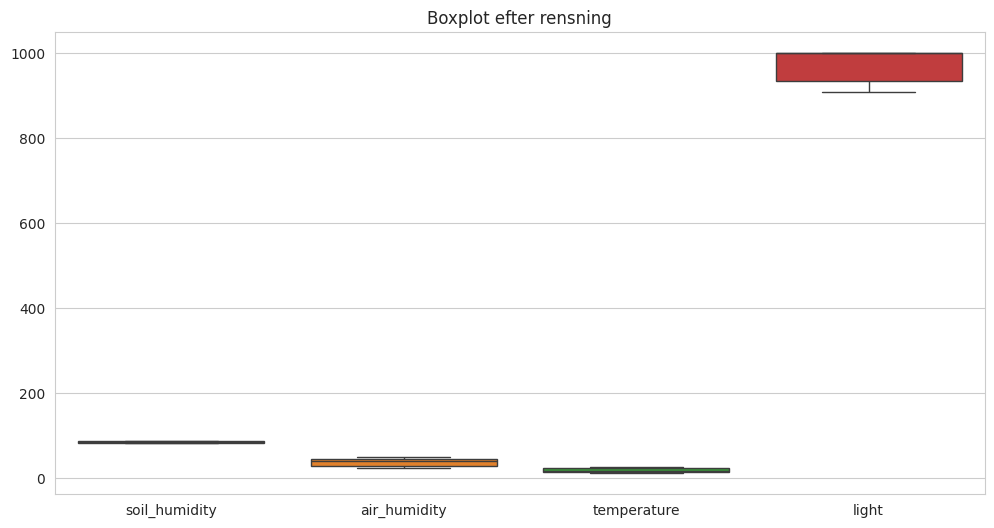

In [121]:
# --- Scatterplot af soil_humidity vs minut_to_dry ---
plt.scatter(df_clean["soil_humidity"], df_clean["minutes_to_dry"], alpha=0.5, color='green')
plt.title("Soil Humidity vs. Minutes to Dry")
plt.xlabel("Soil Humidity")
plt.ylabel("Minutes to Dry")
plt.savefig(f"{output_dir}/scatterplot_soilhumidity_vs_minutestodry.png")
plt.show()

# --- Tidsserieplot af soil_humidity efter rensning ---
plt.title("Tidsserie - Soil Humidity (efter rensning)")
plt.plot(df_clean['timestamp'], df_clean['soil_humidity'], label='Soil Humidity', color='green')
plt.legend()
plt.savefig(f"{output_dir}/soil_humidity_timeseries_after_cleaning.png")
plt.show()

# -- Correlational heatmap efter rensning ---
sns.heatmap(df_scaled.corr(), annot=True, cmap='Greens')
plt.title("Korrelationsmatrix efter rensning")
plt.savefig(f"{output_dir}/correlation_matrix_after_cleaning.png")
plt.show()

# --- Boxplot efter rensning ---
sns.boxplot(data=df_clean[["soil_humidity", "air_humidity", "temperature", "light"]])
plt.title("Boxplot efter rensning")
plt.savefig(f"{output_dir}/boxplot_after_cleaning.png")
plt.show()


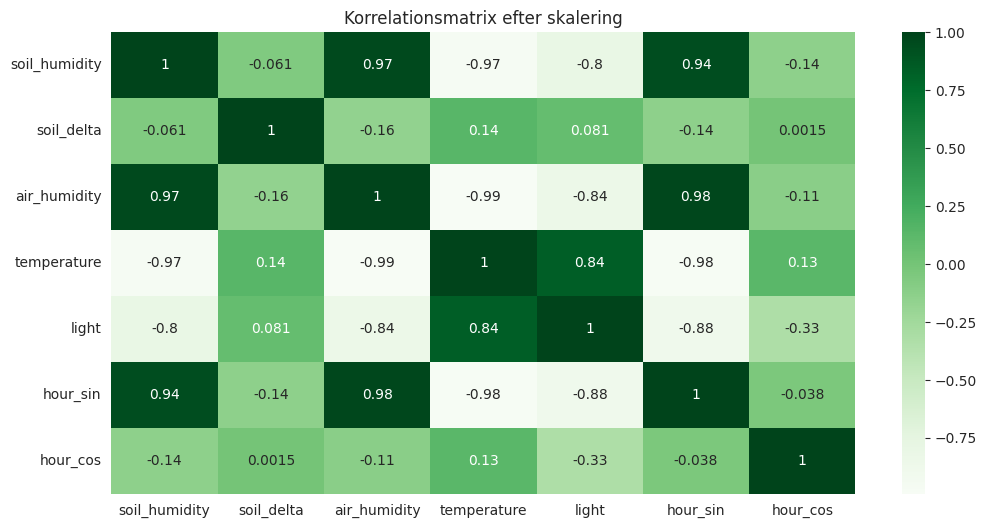

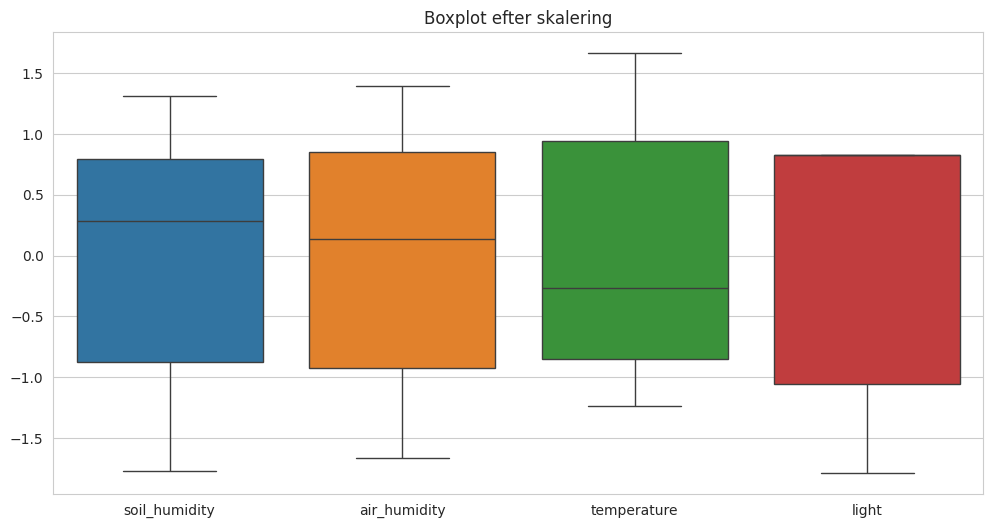

In [122]:
# --- Skalering af df ---
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clean[feature_cols])
df_scaled = pd.DataFrame(scaled_features, columns=feature_cols)

# --- Correlation heatmap efter skalering ---
sns.heatmap(df_scaled.corr(), annot=True, cmap='Greens')
plt.savefig(f"{output_dir}/correlation_heatmap_after_scaling.png")
plt.title("Korrelationsmatrix efter skalering")
plt.show()

# --- Boxplot efter skalering ---
sns.boxplot(data=df_scaled[["soil_humidity", "air_humidity", "temperature", "light"]])
plt.title("Boxplot efter skalering")
plt.savefig(f"{output_dir}/boxplot_after_scaling.png")
plt.show()